In [1]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import validation_curve
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_validate
from statsmodels.stats.outliers_influence import variance_inflation_factor
from warnings import filterwarnings
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
filterwarnings('ignore')

In [40]:
# 데이터 불러오기
train_quality = pd.read_csv('data/train_quality_data.csv',  thousands=',', parse_dates=['time'])
train_problem = pd.read_csv('data/train_problem_data.csv',  thousands=',', parse_dates=['time'])
train_err     = pd.read_csv('data/train_err_data.csv'    ,  thousands=',', parse_dates=['time'])

In [ ]:
# 정의
train_user_id_max = 24999
train_user_id_min = 10000
train_user_number = 15000

test_user_id_max = 44998
test_user_id_min = 30000
test_user_number = 14999


In [27]:
# float으로 변경
train_quality["quality_0"] = train_quality.quality_0.astype(float)
train_quality["quality_1"] = train_quality.quality_1.astype(float)
train_quality["quality_2"] = train_quality.quality_2.astype(float)
train_quality["quality_3"] = train_quality.quality_3.astype(float)
train_quality["quality_4"] = train_quality.quality_4.astype(float)
train_quality["quality_5"] = train_quality.quality_5.astype(float)
train_quality["quality_6"] = train_quality.quality_6.astype(float)
train_quality["quality_7"] = train_quality.quality_7.astype(float)
train_quality["quality_8"] = train_quality.quality_8.astype(float)
train_quality["quality_9"] = train_quality.quality_9.astype(float)
train_quality["quality_10"] = train_quality.quality_10.astype(float)
train_quality["quality_11"] = train_quality.quality_11.astype(float)
train_quality["quality_12"] = train_quality.quality_12.astype(float)

In [28]:
# 정보 확인
train_problem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5429 entries, 0 to 5428
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   user_id  5429 non-null   int64         
 1   time     5429 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 85.0 KB


In [29]:
# 정보 확인
train_quality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828624 entries, 0 to 828623
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time        828624 non-null  datetime64[ns]
 1   user_id     828624 non-null  int64         
 2   fwver       788544 non-null  object        
 3   quality_0   684192 non-null  float64       
 4   quality_1   828624 non-null  float64       
 5   quality_2   788511 non-null  float64       
 6   quality_3   828624 non-null  float64       
 7   quality_4   828624 non-null  float64       
 8   quality_5   828604 non-null  float64       
 9   quality_6   828624 non-null  float64       
 10  quality_7   828624 non-null  float64       
 11  quality_8   828624 non-null  float64       
 12  quality_9   828624 non-null  float64       
 13  quality_10  828624 non-null  float64       
 14  quality_11  828624 non-null  float64       
 15  quality_12  828624 non-null  float64       
dtypes:

In [30]:
# 정보 확인
train_err.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16554663 entries, 0 to 16554662
Data columns (total 6 columns):
 #   Column    Dtype         
---  ------    -----         
 0   user_id   int64         
 1   time      datetime64[ns]
 2   model_nm  object        
 3   fwver     object        
 4   errtype   int64         
 5   errcode   object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 757.8+ MB


# train quality 중복된 퀄리티 에러, 반복 시도로 간주, 삭제<br>
## ( 두 시간 단위로 10분마다 퀄리티 오류가 생기는 것을 발견)

In [31]:
train_quality = train_quality.drop_duplicates()
train_quality

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,2020-11-29 09:00:00,10000,05.15.2138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
6,2020-11-29 09:00:00,10000,05.15.2138,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
12,2020-11-30 21:00:00,10000,05.15.2138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0
22,2020-11-30 21:00:00,10000,05.15.2138,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0
24,2020-11-04 11:00:00,10002,05.15.2138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828612,2020-11-24 03:30:00,24997,04.22.1778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0
828615,2020-11-24 03:30:00,24997,04.22.1778,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0
828619,2020-11-24 03:30:00,24997,04.22.1778,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0
828621,2020-11-24 03:30:00,24997,04.22.1778,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0


# train quality 상관관계

In [34]:
train_quality1 = train_quality.set_index('user_id')
train_quality1.corr()

,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
quality_0,1.000000,0.002533,0.999535,NaN,NaN,0.067202,-0.000641,0.001364,-0.001721,0.627983,0.037553,0.008226,0.015000
quality_1,0.002533,1.000000,0.002185,NaN,NaN,0.008600,0.024817,0.009660,0.664090,0.000604,0.004294,0.382537,0.013020
quality_2,0.999535,0.002185,1.000000,NaN,NaN,0.068499,0.001420,0.001232,-0.000295,0.597484,0.034181,0.009229,0.009325
quality_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
quality_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
quality_5,0.067202,0.008600,0.068499,NaN,NaN,1.000000,0.012080,0.017131,0.000128,0.045884,0.729045,0.034146,0.068899
quality_6,-0.000641,0.024817,0.001420,NaN,NaN,0.012080,1.000000,0.693281,0.003656,0.002563,0.018123,0.037247,-0.001181
quality_7,0.001364,0.009660,0.001232,NaN,NaN,0.017131,0.693281,1.000000,0.002862,0.003335,0.026515,0.016269,-0.002663
quality_8,-0.001721,0.664090,-0.000295,NaN,NaN,0.000128,0.003656,0.002862,1.000000,-0.000537,0.000033,0.001869,0.015031
quality_9,0.627983,0.000604,0.597484,NaN,NaN,0.045884,0.002563,0.003335,-0.000537,1.000000,0.050694,0.004816,0.011722


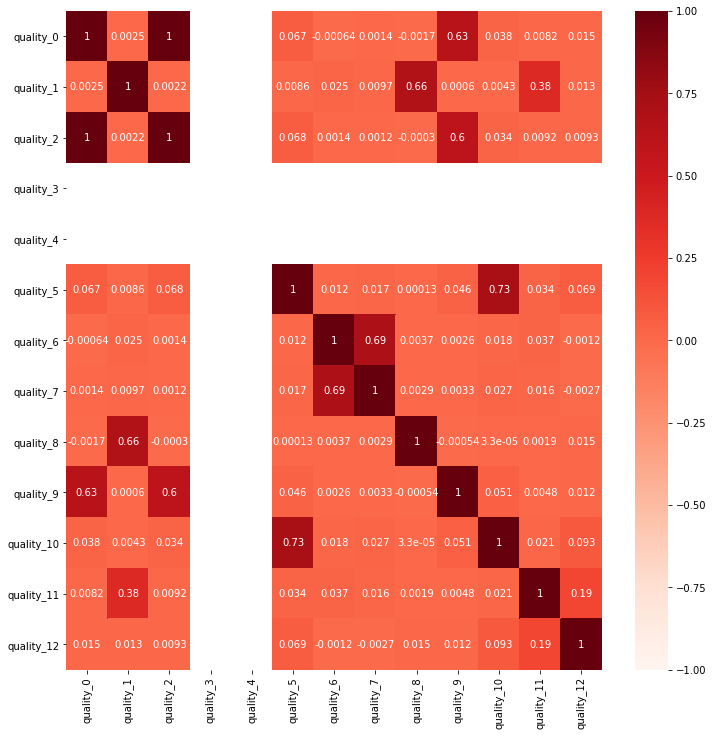

In [35]:
plt.figure(figsize=(12,12.12))
sns.heatmap(train_quality1.corr(),vmin=-1, vmax = 1, cmap='Reds', annot=True)
plt.show()

In [36]:
# 퀄리티 5-10, 퀄리티 6-7, 퀄리티 0-9, 퀄리티 2-9, 퀄리티 1-8은 어느정도 상관관계가 있다는 것을 확인

# train_quality - train_problem 간 상관관계

In [49]:
train_quality.set_index('user_id',inplace=True)
train_problem.set_index('user_id',inplace=True)

In [51]:
# 퀄리티 에러가 생긴 사람 중 불만을 접수한 사람



quality_problem = pd.merge(train_quality,train_problem, on='user_id')
quality_problem = quality_problem.rename({'time_x':'quality_time','time_y':'problem_time'}, axis='columns')
quality_problem = quality_problem[['fwver','quality_time','problem_time','quality_0','quality_1','quality_2','quality_3','quality_4','quality_5','quality_6','quality_7','quality_8','quality_9','quality_10','quality_11','quality_12']]

quality_problem

,fwver,quality_time,problem_time,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
user_id,,,,,,,,,,,,,,,,
10004,04.22.1750,2020-11-02 23:20:00,2020-11-04 12:00:00,0.0,0,0.0,0,0,0.0,0,0,0,0,3,0,0
10004,04.22.1750,2020-11-02 23:20:00,2020-11-04 12:00:00,0.0,0,0.0,0,0,1.0,0,0,0,0,3,0,0
10004,04.22.1750,2020-11-02 23:20:00,2020-11-04 12:00:00,0.0,0,0.0,0,0,0.0,0,0,0,0,3,0,0
10004,04.22.1750,2020-11-02 23:20:00,2020-11-04 12:00:00,0.0,0,0.0,0,0,0.0,0,0,0,0,3,0,0
10004,04.22.1750,2020-11-02 23:20:00,2020-11-04 12:00:00,0.0,0,0.0,0,0,2.0,0,0,0,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24997,04.22.1778,2020-11-24 03:30:00,2020-11-15 15:00:00,0.0,0,0.0,0,0,1.0,0,0,0,0,17,0,0
24997,04.22.1778,2020-11-24 03:30:00,2020-11-15 15:00:00,0.0,0,0.0,0,0,0.0,0,0,0,0,17,0,0
24997,04.22.1778,2020-11-24 03:30:00,2020-11-15 15:00:00,0.0,0,0.0,0,0,3.0,0,0,0,0,17,0,0


In [52]:
# 데이터에 -1부터 70000까지 다양하게 있다. 간단하게 퀄리티오류가 발생하면 카운트

#### 불만신고접수를 한 사람

In [53]:
# 15000명 중 불만을 표시한 사람 3082명(만족하지 못했다.)
sr_complain = quality_problem.index.unique()
sr_complain

Int64Index([10004, 10005, 10006, 10013, 10019, 10021, 10027, 10038, 10047,
            10050,
            ...
            24951, 24953, 24955, 24964, 24965, 24967, 24977, 24984, 24990,
            24997],
           dtype='int64', name='user_id', length=3167)

In [57]:
quality_problem_nan = quality_problem.replace(0,np.NaN) # 카운트를 하기 위해 nan으로 변경
quality_problem_nan

,fwver,quality_time,problem_time,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
user_id,,,,,,,,,,,,,,,,
10004,04.22.1750,2020-11-02 23:20:00,2020-11-04 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
10004,04.22.1750,2020-11-02 23:20:00,2020-11-04 12:00:00,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN
10004,04.22.1750,2020-11-02 23:20:00,2020-11-04 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
10004,04.22.1750,2020-11-02 23:20:00,2020-11-04 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
10004,04.22.1750,2020-11-02 23:20:00,2020-11-04 12:00:00,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24997,04.22.1778,2020-11-24 03:30:00,2020-11-15 15:00:00,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,17.0,NaN,NaN
24997,04.22.1778,2020-11-24 03:30:00,2020-11-15 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,NaN,NaN
24997,04.22.1778,2020-11-24 03:30:00,2020-11-15 15:00:00,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,17.0,NaN,NaN


In [58]:
quality_problem_count = quality_problem_nan.groupby('user_id').count()[['quality_0','quality_1','quality_2','quality_3','quality_4','quality_5','quality_6','quality_7','quality_8','quality_9','quality_10','quality_11','quality_12']]
quality_problem_count


,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
user_id,,,,,,,,,,,,,
10004,2,2,2,0,0,5,3,12,0,0,24,2,0
10005,10,10,10,0,0,16,12,12,0,0,24,10,0
10006,0,0,0,0,0,9,3,36,0,0,108,0,0
10013,42,42,42,0,0,94,42,0,0,0,144,42,0
10019,29,43,29,0,0,90,30,12,36,0,216,29,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24967,5,5,5,0,0,7,6,12,0,0,24,5,0
24977,0,0,0,0,0,2,0,0,0,0,12,0,0
24984,13,13,13,0,0,17,14,12,0,0,48,13,0


#### 불만신고접수하지 않은 사람

In [59]:
quality_noploblem = train_quality.drop(index=quality_problem_count.index) 
quality_noploblem

,time,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
user_id,,,,,,,,,,,,,,,
10000,2020-11-29 09:00:00,05.15.2138,0.0,0,0.0,0,0,0.0,0,0,0,0,4,0,0
10000,2020-11-29 09:00:00,05.15.2138,0.0,0,0.0,0,0,0.0,0,0,0,0,4,0,0
10000,2020-11-29 09:00:00,05.15.2138,0.0,0,0.0,0,0,0.0,0,0,0,0,4,0,0
10000,2020-11-29 09:00:00,05.15.2138,0.0,0,0.0,0,0,0.0,0,0,0,0,4,0,0
10000,2020-11-29 09:00:00,05.15.2138,0.0,0,0.0,0,0,0.0,0,0,0,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,2020-11-29 00:20:00,04.33.1261,0.0,0,0.0,0,0,0.0,0,0,0,0,3,0,0
24995,2020-11-29 00:20:00,04.33.1261,0.0,0,0.0,0,0,0.0,0,0,0,0,3,0,0
24995,2020-11-29 00:20:00,04.33.1261,0.0,0,0.0,0,0,3.0,0,0,0,0,3,0,0


In [60]:
quality_noploblem_nan = quality_noploblem.replace(0,np.NaN) # 카운트를 하기 위해 nan으로 변경
quality_noploblem_nan

,time,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
user_id,,,,,,,,,,,,,,,
10000,2020-11-29 09:00:00,05.15.2138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN
10000,2020-11-29 09:00:00,05.15.2138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN
10000,2020-11-29 09:00:00,05.15.2138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN
10000,2020-11-29 09:00:00,05.15.2138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN
10000,2020-11-29 09:00:00,05.15.2138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,2020-11-29 00:20:00,04.33.1261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
24995,2020-11-29 00:20:00,04.33.1261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
24995,2020-11-29 00:20:00,04.33.1261,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN


In [61]:
quality_noploblem_count = quality_noploblem_nan.groupby('user_id').count()[['quality_0','quality_1','quality_2','quality_3','quality_4','quality_5','quality_6','quality_7','quality_8','quality_9','quality_10','quality_11','quality_12']]
quality_noploblem_count

,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
user_id,,,,,,,,,,,,,
10000,0,0,0,0,0,2,0,0,0,0,24,0,0
10002,3,2,3,0,0,14,5,24,0,12,84,2,0
10010,9,10,9,0,0,10,9,0,12,0,12,9,0
10012,0,0,0,0,0,3,0,0,0,0,24,0,0
10020,21,21,21,0,0,25,21,0,0,0,48,21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24985,0,0,0,0,0,2,0,0,0,0,12,0,0
24986,21,24,21,0,0,42,22,12,24,0,84,21,0
24992,12,12,12,0,0,16,12,0,0,0,36,12,0


quality_noploblem # 불만신고접수하지 않은 id <br>
quality_problem # 불만신고접수한 id (-1)<br>
quality_problem_count # 불만신고접수한 id(count)<br>
quality_noploblem_count # 불만신고접수하지 않은 id(count)<br>
quality_problem.index.unique() # 퀄리티 오류로 인해 불만신고접수한 id 수 (3082)<br>
quality_noploblem.index.unique() # 퀄리티 오류는 떴으나 불만신고접수하지 않은 id 수 (4940)

In [ ]:
# 불만신고접수를 하는데 있어 특정 퀄리티 오류가 영향을 줄 것이라 생각

In [62]:
quality_problem_count[quality_problem_count['quality_12']>0]

,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
user_id,,,,,,,,,,,,,
10150,45,45,45,0,0,63,45,0,0,0,120,46,12
10301,106,136,106,0,0,161,108,24,240,0,444,131,252
10531,0,70,70,0,0,134,69,0,12,12,384,83,120
10780,58,64,58,0,0,64,60,24,48,0,72,60,24
10822,92,98,92,0,0,148,140,216,48,0,216,94,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24749,0,47,40,0,0,55,40,0,72,0,168,106,564
24824,0,37,36,0,0,41,36,0,12,0,60,56,204
24934,0,169,168,0,0,502,168,12,24,12,720,196,216


In [63]:
quality_noploblem_count[quality_noploblem_count['quality_12']>0]

,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
user_id,,,,,,,,,,,,,
10167,0,176,172,0,0,248,172,0,48,0,456,197,240
10217,0,87,77,0,0,80,77,0,120,0,36,97,204
10265,0,28,226,0,0,256,40,108,24,708,900,30,36
10268,0,0,0,0,0,0,1,12,0,0,0,1,12
10346,48,48,48,0,0,94,48,0,0,0,204,50,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24402,125,57,125,0,0,136,75,84,0,180,192,58,12
24449,2,2,2,0,0,4,2,0,0,0,24,3,12
24489,33,19,33,0,0,35,24,36,0,72,72,20,12


In [ ]:
# 결과
# quality_problem_count ->  
# 0 = 2260, 1 = 2387, 2 = 2337, 3 = 0, 4 = 0, 5 = 3035, 6 = 2520, 7 = 1045, 8 = 634, 9 = 124 , 10 = 2973,, 11 = 2333, 12 = 129
# quality_noploblem_count -> 
# 0 = 3147, 1 = 3535, 2 = 3437, 3 = 0, 4 = 0, 5 = 4863, 6 = 3768, 7 = 1125, 8 = 632, 9 = 256 , 10 = 4729, 11 = 3449, 12 = 148

# 바 그래프  quality_problem_count, quality_noploblem_count 비교

In [ ]:
# 불만신고접수에 있어 특정 퀄리티 오류가 영향을 주지 않는 것을 확인

In [64]:
quality_problem.index.unique() # 퀄리티 오류로 인해 불만신고접수한 사람 3167명

Int64Index([10004, 10005, 10006, 10013, 10019, 10021, 10027, 10038, 10047,
            10050,
            ...
            24951, 24953, 24955, 24964, 24965, 24967, 24977, 24984, 24990,
            24997],
           dtype='int64', name='user_id', length=3167)

In [65]:
quality_noploblem.index.unique()  # 퀄리티 오류는 발생했으나 불만신고접수 하지 않은 사람 5114명

Int64Index([10000, 10002, 10010, 10012, 10020, 10022, 10025, 10030, 10032,
            10033,
            ...
            24969, 24979, 24980, 24981, 24982, 24985, 24986, 24992, 24993,
            24995],
           dtype='int64', name='user_id', length=5114)

In [ ]:
# 퀄리티 오류가 발생하지 않았으나 불만을 표현한 사람 6719명 (15000-8281)

# user_id 당 퀄리티 에러로 인한 불만신고접수 유무에 따라 0(접수 x), 1로 구분

In [76]:
id=[]
quality=[]
for i in tqdm(range(10000,25000)) :
    
    id.append(i)
    if quality_problem_count.sum(axis=1)[i-10000:i-9999].values>1 :
        quality.append([quality_problem.index.unique()-10000]==1)
    else :
         quality.append([quality_problem.index.unique()-10000]==0)

quality = np.zeros(15000)
quality[quality_problem.index.unique()-10000] = 1 
print(quality)

100%|██████████| 15000/15000 [00:53<00:00, 278.75it/s]

[0. 0. 0. ... 1. 0. 0.]


In [77]:
# 데이터프레임 만들기
quality_ox=pd.DataFrame({'user_id':id,'quality_problem':quality})
quality_ox

,user_id,quality_problem
0,10000,0.0
1,10001,0.0
2,10002,0.0
3,10003,0.0
4,10004,1.0
...,...,...
14995,24995,0.0
14996,24996,0.0
14997,24997,1.0
14998,24998,0.0


In [78]:
# 팀원 자료와 합치기
err_problem_summary = pd.read_csv('data/err_problem_summary.csv')
err_problem_summary2 = pd.merge(err_problem_summary,quality_ox, on='user_id')
err_problem_summary2.head()

,Unnamed: 0,user_id,problem,start_t_errlog,rec_t_problem,time_interval_hour,n_errlogs,model,n_models,fwver,n_fwvers,errtype,n_errtypes,quality_problem
0,0,10000,0.0,2020-11-01 02:56:16,-1,-1,317,['model_3'],1,['05.15.2138'],1,[15 12 11 16 4 26 10 14 3 13 6 7 27 28],14,0.0
1,1,10001,1.0,2020-11-01 02:04:15,2020-11-13T19:00:00.000000000,"(304.0,)",2365,['model_2'],1,['04.33.1185' '04.33.1261'],2,[15 31 33 12 11 22 26 16 41 5 14 40 34 13 6 ...,26,0.0
2,2,10002,0.0,2020-11-01 03:02:51,-1,-1,306,['model_3'],1,['05.15.2138'],1,[11 12 16 4 26 15 24 27 28 13 3 7 6 14 5 10],16,0.0
3,3,10003,0.0,2020-11-01 18:25:32,-1,-1,306,['model_2'],1,['04.33.1185' '04.33.1261'],2,[15 16 31 40 22 23 26 6 7 5 17 38 33 12 11 ...,18,0.0
4,4,10004,1.0,2020-11-01 02:46:47,2020-11-04T12:00:00.000000000,"(81.0,)",777,['model_0'],1,['04.22.1750' '04.22.1778'],2,[13 12 14 6 7 15 33 11 22 26 16 31 23 40 4 ...,18,1.0


In [ ]:
# 저장
err_problem_summary2.to_csv(PATH+'err_problem_summary2.csv')

# fmver

In [67]:
# 시스템 품질 변화로 인한 사용자 불편 예지라는 제목을 보고 펌웨어 버전의 변화와 사용자 불편이 상관관계가 있을 것이라 생각

In [68]:
train_quality_nan = train_quality.replace(0,np.NaN)
train_quality_nan

,time,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
user_id,,,,,,,,,,,,,,,
10000,2020-11-29 09:00:00,05.15.2138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN
10000,2020-11-29 09:00:00,05.15.2138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN
10000,2020-11-29 09:00:00,05.15.2138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN
10000,2020-11-29 09:00:00,05.15.2138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN
10000,2020-11-29 09:00:00,05.15.2138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24997,2020-11-24 03:30:00,04.22.1778,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,17.0,NaN,NaN
24997,2020-11-24 03:30:00,04.22.1778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,NaN,NaN
24997,2020-11-24 03:30:00,04.22.1778,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,17.0,NaN,NaN


In [71]:
len(fwver_quality.index.unique())

27

In [69]:
# 펌웨어 별 퀄리티 오류
fwver_quality = train_quality_nan.groupby('fwver').count()[['quality_0','quality_1','quality_2','quality_3','quality_4','quality_5','quality_6','quality_7','quality_8','quality_9','quality_10','quality_11','quality_12']]
fwver_quality


,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
fwver,,,,,,,,,,,,,
03.11.1149,0,2,5,0,0,32,2,0,0,24,204,2,0
03.11.1167,0,14060,14632,0,0,28891,14250,4320,5304,6528,83184,15780,22584
04.16.3345,0,0,0,0,0,0,3,12,0,0,0,0,0
04.16.3439,0,1,0,0,0,2,1,12,12,0,12,0,0
04.16.3553,19361,20224,19364,0,0,56232,21201,9564,7776,24,108732,19373,144
04.16.3571,370,387,370,0,0,890,389,192,156,0,2112,370,0
04.22.1442,14,14,14,0,0,25,14,0,0,0,84,14,0
04.22.1656,0,0,0,0,0,0,2,12,0,0,0,0,0
04.22.1666,2,3,2,0,0,221,2,0,12,0,636,2,0


In [47]:
g = train_err.fwver.unique()
g = pd.DataFrame({'fwver':g})
g

,fwver
0,05.15.2138
1,04.33.1185
2,04.33.1261
3,04.22.1750
4,04.22.1778
5,04.16.3553
6,04.33.1149
7,04.16.3571
8,05.66.3237
9,05.66.3571


In [72]:
fwver_all = pd.merge(g, fwver_quality, on='fwver', how='outer')
fwver_all = fwver_all.replace(np.NaN,0)
fwver_all = fwver_all.set_index('fwver')
fwver_all

,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
fwver,,,,,,,,,,,,,
05.15.2138,39892.0,30340.0,39892.0,0.0,0.0,81515.0,32485.0,14676.0,6444.0,25080.0,157188.0,29703.0,1488.0
04.33.1185,12545.0,12841.0,12545.0,0.0,0.0,36680.0,13397.0,4980.0,2748.0,0.0,64824.0,12647.0,984.0
04.33.1261,28478.0,29418.0,28478.0,0.0,0.0,71871.0,30429.0,10284.0,7080.0,0.0,126180.0,28650.0,1608.0
04.22.1750,27501.0,27985.0,27501.0,0.0,0.0,73251.0,28928.0,9420.0,4260.0,0.0,139500.0,27514.0,144.0
04.22.1778,11215.0,11567.0,11215.0,0.0,0.0,31012.0,11729.0,3804.0,2592.0,0.0,54528.0,11258.0,384.0
04.16.3553,19361.0,20224.0,19364.0,0.0,0.0,56232.0,21201.0,9564.0,7776.0,24.0,108732.0,19373.0,144.0
04.33.1149,134.0,139.0,134.0,0.0,0.0,324.0,149.0,108.0,48.0,0.0,768.0,134.0,0.0
04.16.3571,370.0,387.0,370.0,0.0,0.0,890.0,389.0,192.0,156.0,0.0,2112.0,370.0,0.0
05.66.3237,160.0,165.0,160.0,0.0,0.0,305.0,164.0,48.0,60.0,0.0,540.0,160.0,0.0


In [75]:
len(fwver_all.index)

38

In [ ]:
# 펌웨어 저장
fwver_all.to_csv(PATH + 'fwver_all.csv')